# Mini-Language Learning System

## A Complete ML Pipeline Using Only Addition and Subtraction

This notebook demonstrates a custom machine learning system that learns a 10-word language using **only addition and subtraction operations** - no matrix multiplication, no dot products, no standard neural network operations.

### Key Constraints:
- ✅ **Allowed**: Addition, subtraction, comparisons, search/lookups
- ❌ **Not Allowed**: Matrix multiplication, fancy linear algebra, standard NN operations

### System Overview:
1. **10-word vocabulary**: I, YOU, GO, GIVE, TAKE, LEFT, RIGHT, HERE, YES, NO
2. **4 tasks**: Intent classification, action mapping, response generation, direction detection
3. **Learning mechanism**: Counting-based perceptron with ±1 updates
4. **Features**: Unigrams and bigrams
5. **Extensibility**: Can add new words and new tasks

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.append('src')

# Core imports
from vocab import get_default_vocab
from tasks import get_default_task_registry
from model import AddSubModel
from data_utils import Dataset, preprocess_dataset, combine_datasets
from training import Trainer, TrainingHistory
from evaluation import Evaluator
from extensions import LanguageExtender
from persistence import save_model_checkpoint, load_model_checkpoint

# Plotting
import matplotlib.pyplot as plt
import numpy as np

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✓ All imports successful")

✓ All imports successful


## 2. Define the 10-Word Language

Our mini-language consists of exactly 10 words, carefully chosen to enable meaningful communication.

In [2]:
# Create vocabulary
vocab = get_default_vocab()

print(vocab)
print(f"\nVocabulary size: {len(vocab)} words")
print(f"\nSemantic groupings:")
for category, words in vocab.get_semantic_info().items():
    print(f"  {category:12s}: {', '.join(words)}")

# Test tokenization
print("\nExample sentences:")
examples = ["YOU GO LEFT", "I TAKE HERE", "YOU GIVE", "YES", "NO"]
for sent in examples:
    tokens = vocab.tokenize(sent)
    print(f"  '{sent}' → {tokens}")

Vocabulary(10 words: I, YOU, GO, GIVE, TAKE, LEFT, RIGHT, HERE, YES, NO)

Vocabulary size: 10 words

Semantic groupings:
  agents      : I, YOU
  actions     : GO, GIVE, TAKE
  locations   : LEFT, RIGHT, HERE
  logic       : YES, NO

Example sentences:
  'YOU GO LEFT' → ['YOU', 'GO', 'LEFT']
  'I TAKE HERE' → ['I', 'TAKE', 'HERE']
  'YOU GIVE' → ['YOU', 'GIVE']
  'YES' → ['YES']
  'NO' → ['NO']


## 3. Define Tasks

With these 10 words, we can perform 4 different tasks.

In [3]:
# Create task registry
task_registry = get_default_task_registry()

print("Task Registry:")
print("=" * 70)
for task_name in task_registry.get_task_names():
    task = task_registry.get_task(task_name)
    print(f"\n{task.name}:")
    print(f"  Description: {task.description}")
    print(f"  Labels ({len(task.labels)}): {', '.join(task.labels)}")

Registered task: intent_classification (5 labels)
Registered task: action_mapping (7 labels)
Registered task: response_generation (9 labels)
Registered task: direction_detection (4 labels)
Task Registry:

intent_classification:
  Description: Classify the intent of a sentence
  Labels (5): COMMAND, STATEMENT, CONFIRMATION, NEGATION, QUERY

action_mapping:
  Description: Map a sentence to a concrete action
  Labels (7): MOVE_LEFT, MOVE_RIGHT, MOVE_HERE, GIVE_ITEM, TAKE_ITEM, STAY, NONE

response_generation:
  Description: Generate an appropriate response
  Labels (9): YES, NO, I_GO_LEFT, I_GO_RIGHT, I_TAKE, I_GIVE, YOU_TAKE, YOU_GIVE, SILENT

direction_detection:
  Description: Detect which direction is mentioned
  Labels (4): LEFT, RIGHT, HERE, NONE


## 4. Load Training Data

We load pre-generated synthetic datasets for each task.

In [4]:
# Load datasets for all tasks
import os

wrkg_dir = os.getcwd()
data_dir = os.path.join(wrkg_dir, "mini_language_model", "data", "tasks")
all_train_datasets = []
all_val_datasets = []
all_test_datasets = []

print("Loading datasets...")
print("=" * 70)

for task_name in task_registry.get_task_names():
    task_dir = Path(data_dir) / task_name
    
    train_ds = Dataset.load_jsonl(str(task_dir / "train.jsonl"), name=f"{task_name}_train")
    val_ds = Dataset.load_jsonl(str(task_dir / "val.jsonl"), name=f"{task_name}_val")
    test_ds = Dataset.load_jsonl(str(task_dir / "test.jsonl"), name=f"{task_name}_test")
    
    # Preprocess: convert text to indices
    train_ds = preprocess_dataset(train_ds, vocab)
    val_ds = preprocess_dataset(val_ds, vocab)
    test_ds = preprocess_dataset(test_ds, vocab)
    
    all_train_datasets.append(train_ds)
    all_val_datasets.append(val_ds)
    all_test_datasets.append(test_ds)
    
    print(f"\n{task_name}:")
    print(f"  Train: {len(train_ds)} examples")
    print(f"  Val:   {len(val_ds)} examples")
    print(f"  Test:  {len(test_ds)} examples")

# Combine all datasets
train_dataset = combine_datasets(all_train_datasets, name="combined_train")
val_dataset = combine_datasets(all_val_datasets, name="combined_val")
test_dataset = combine_datasets(all_test_datasets, name="combined_test")

print("\n" + "=" * 70)
print(f"Combined datasets:")
print(f"  Train: {len(train_dataset)} examples")
print(f"  Val:   {len(val_dataset)} examples")
print(f"  Test:  {len(test_dataset)} examples")

Loading datasets...
Loaded 140 examples from c:\Users\prave\tulips\mini_language_model\data\tasks\intent_classification\train.jsonl
Loaded 30 examples from c:\Users\prave\tulips\mini_language_model\data\tasks\intent_classification\val.jsonl
Loaded 30 examples from c:\Users\prave\tulips\mini_language_model\data\tasks\intent_classification\test.jsonl

intent_classification:
  Train: 140 examples
  Val:   30 examples
  Test:  30 examples
Loaded 138 examples from c:\Users\prave\tulips\mini_language_model\data\tasks\action_mapping\train.jsonl
Loaded 29 examples from c:\Users\prave\tulips\mini_language_model\data\tasks\action_mapping\val.jsonl
Loaded 31 examples from c:\Users\prave\tulips\mini_language_model\data\tasks\action_mapping\test.jsonl

action_mapping:
  Train: 138 examples
  Val:   29 examples
  Test:  31 examples
Loaded 134 examples from c:\Users\prave\tulips\mini_language_model\data\tasks\response_generation\train.jsonl
Loaded 28 examples from c:\Users\prave\tulips\mini_language_

## 5. Create the Model

Our model uses **only addition and subtraction** for both prediction and learning.

In [5]:
# Create model
task_labels = {name: task.labels for name, task in task_registry.tasks.items()}
model = AddSubModel(vocab_size=len(vocab), task_labels=task_labels, use_bigrams=True)

print("Model created:")
print(model)
print("\nInitial statistics:")
stats = model.get_stats()
for key, value in stats.items():
    print(f"  {key:25s}: {value}")

print("\n" + "=" * 70)
print("How the model works:")
print("  1. Prediction: Sum scores for all features (unigrams + bigrams)")
print("     - For each label, score = Σ(feature_scores) [ADDITION ONLY]")
print("     - Return label with max score (argmax)")
print("  2. Learning: On mistakes, update parameters by ±1")
print("     - Correct label features: +1")
print("     - Predicted label features: -1")
print("  3. NO matrix multiplication, NO dot products!")

Model created:
AddSubModel(vocab=10, tasks=4, params=0/0, updates=0)

Initial statistics:
  total_parameters         : 0
  non_zero_parameters      : 0
  sparsity                 : 1.0
  update_count             : 0
  prediction_count         : 0
  num_tasks                : 4

How the model works:
  1. Prediction: Sum scores for all features (unigrams + bigrams)
     - For each label, score = Σ(feature_scores) [ADDITION ONLY]
     - Return label with max score (argmax)
  2. Learning: On mistakes, update parameters by ±1
     - Correct label features: +1
     - Predicted label features: -1
  3. NO matrix multiplication, NO dot products!


## 6. Training

Train the model for multiple epochs and track learning progress.

In [13]:
# Create trainer
trainer = Trainer(model, vocab, verbose=True)

# Train for multiple epochs
NUM_EPOCHS = 20

print(f"Training for {NUM_EPOCHS} epochs...\n")
history = trainer.train(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=NUM_EPOCHS,
    shuffle=True
)

print(f"\nTraining complete!")
print(f"Final model: {model}")

Training for 20 epochs...


Starting training for 20 epochs...
Train dataset: 552 examples
Val dataset: 117 examples
Epoch   1/20: train_acc=1.0000, train_loss=0, val_acc=1.0000, updates=0, time=0.00s
Epoch   2/20: train_acc=1.0000, train_loss=0, val_acc=1.0000, updates=0, time=0.00s
Epoch   3/20: train_acc=1.0000, train_loss=0, val_acc=1.0000, updates=0, time=0.00s
Epoch   4/20: train_acc=1.0000, train_loss=0, val_acc=1.0000, updates=0, time=0.00s
Epoch   5/20: train_acc=1.0000, train_loss=0, val_acc=1.0000, updates=0, time=0.01s
Epoch   6/20: train_acc=1.0000, train_loss=0, val_acc=1.0000, updates=0, time=0.00s
Epoch   7/20: train_acc=1.0000, train_loss=0, val_acc=1.0000, updates=0, time=0.00s
Epoch   8/20: train_acc=1.0000, train_loss=0, val_acc=1.0000, updates=0, time=0.00s
Epoch   9/20: train_acc=1.0000, train_loss=0, val_acc=1.0000, updates=0, time=0.00s
Epoch  10/20: train_acc=1.0000, train_loss=0, val_acc=1.0000, updates=0, time=0.00s
Epoch  11/20: train_acc=1.0000, train_loss=

## 7. Visualize Learning Curves

Plot training and validation accuracy over epochs.

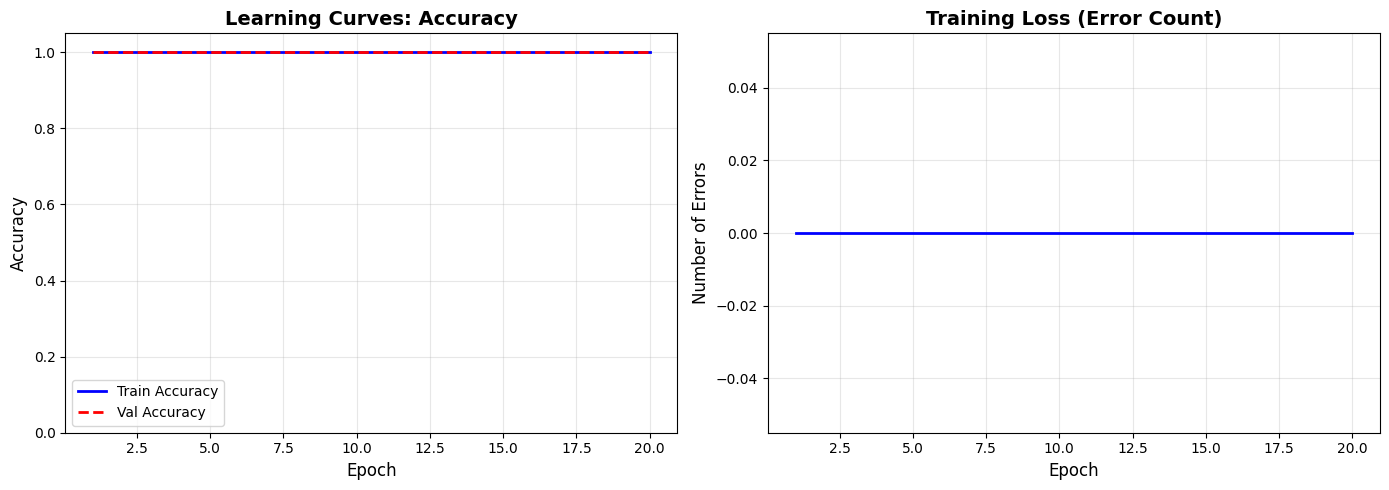


Best validation accuracy: 1.0000 at epoch 1
Final train accuracy: 1.0000
Final val accuracy: 1.0000


In [14]:
# Extract metrics
epochs = [m.epoch for m in history.metrics]
train_accs = [m.train_accuracy for m in history.metrics]
val_accs = [m.val_accuracy for m in history.metrics]
train_losses = [m.train_loss for m in history.metrics]

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(epochs, train_accs, 'b-', label='Train Accuracy', linewidth=2)
axes[0].plot(epochs, val_accs, 'r--', label='Val Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Learning Curves: Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Plot training loss (number of errors)
axes[1].plot(epochs, train_losses, 'b-', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Number of Errors', fontsize=12)
axes[1].set_title('Training Loss (Error Count)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models/learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Print best performance
best_epoch, best_val_acc = history.get_best_val_accuracy()
print(f"\nBest validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Final train accuracy: {train_accs[-1]:.4f}")
print(f"Final val accuracy: {val_accs[-1]:.4f}")

## 8. Evaluation on Test Set

Comprehensive evaluation with per-task metrics and confusion matrices.

In [15]:
# Create evaluator
evaluator = Evaluator(model, vocab)

# Evaluate on test set
print("Evaluating on test set...\n")
test_results = evaluator.evaluate_dataset(test_dataset)

# Print comprehensive report
evaluator.print_evaluation_report(test_results, show_errors=True, max_errors=5)

Evaluating on test set...


EVALUATION REPORT

Overall Performance:
  Accuracy: 1.0000 (100.00%)
  Total Examples: 121
  Total Errors: 0

Task: intent_classification

Accuracy: 1.0000 (100.00%)
Examples: 30
Errors: 0

Macro-Averaged Metrics:
  Precision: 0.8000
  Recall: 0.8000
  F1 Score: 0.8000

Per-Class Metrics:
  COMMAND:
    Precision: 1.0000
    Recall:    1.0000
    F1 Score:  1.0000
    Support:   6
  STATEMENT:
    Precision: 1.0000
    Recall:    1.0000
    F1 Score:  1.0000
    Support:   10
  CONFIRMATION:
    Precision: 1.0000
    Recall:    1.0000
    F1 Score:  1.0000
    Support:   8
  NEGATION:
    Precision: 1.0000
    Recall:    1.0000
    F1 Score:  1.0000
    Support:   6
  QUERY:
    Precision: 0.0000
    Recall:    0.0000
    F1 Score:  0.0000
    Support:   0

Confusion Matrix:
           |  COMMAND STATEMEN CONFIRMA NEGATION    QUERY
---------------------------------------------------------
COMMAND    |        6        0        0        0        0
STATEMENT  |

## 9. Feature Importance Analysis

See which words and bigrams are most important for each task.

In [16]:
# Analyze feature importance for each task
for task_name in task_registry.get_task_names():
    print("\n" + "="*70)
    evaluator.print_feature_importance(task_name, top_k=10)



Top 10 Most Important Features for 'intent_classification':
------------------------------------------------------------
   1. unigram: 'YES'                           importance: 2
   2. unigram: 'YOU'                           importance: 2
   3. bigram: 'YOU GO'                         importance: 2
   4. unigram: 'I'                             importance: 2
   5. bigram: 'I GO'                           importance: 2
   6. unigram: 'NO'                            importance: 2
   7. unigram: 'GO'                            importance: 0
   8. unigram: 'LEFT'                          importance: 0
   9. bigram: 'GO LEFT'                        importance: 0
  10. unigram: 'TAKE'                          importance: 0


Top 10 Most Important Features for 'action_mapping':
------------------------------------------------------------
   1. bigram: 'GO HERE'                        importance: 6
   2. unigram: 'GIVE'                          importance: 4
   3. unigram: 'TAKE'        

## 10. Interactive Testing

Test the model with custom inputs.

In [17]:
def test_sentence(sentence, task_name):
    """Test a sentence on a specific task."""
    try:
        indices = vocab.sentence_to_indices(sentence)
        prediction = model.predict(indices, task_name)
        print(f"Input: '{sentence}'")
        print(f"Task: {task_name}")
        print(f"Prediction: {prediction}")
        print()
    except Exception as e:
        print(f"Error: {e}\n")

# Test examples
print("Testing custom sentences:\n")
print("="*70)

test_sentence("YOU GO LEFT", "intent_classification")
test_sentence("YOU GO LEFT", "action_mapping")
test_sentence("YOU GO LEFT", "direction_detection")
test_sentence("YOU GO LEFT", "response_generation")

print("="*70)
test_sentence("I GIVE", "intent_classification")
test_sentence("I GIVE", "action_mapping")

print("="*70)
test_sentence("YES", "intent_classification")
test_sentence("NO", "intent_classification")

Testing custom sentences:

Input: 'YOU GO LEFT'
Task: intent_classification
Prediction: COMMAND

Input: 'YOU GO LEFT'
Task: action_mapping
Prediction: MOVE_LEFT

Input: 'YOU GO LEFT'
Task: direction_detection
Prediction: LEFT

Input: 'YOU GO LEFT'
Task: response_generation
Prediction: I_GO_LEFT

Input: 'I GIVE'
Task: intent_classification
Prediction: STATEMENT

Input: 'I GIVE'
Task: action_mapping
Prediction: GIVE_ITEM

Input: 'YES'
Task: intent_classification
Prediction: CONFIRMATION

Input: 'NO'
Task: intent_classification
Prediction: NEGATION



## 11. Extensibility: Adding a New Word

Demonstrate adding a new word to the vocabulary and retraining.

In [18]:
# Save current model state
model_dir = os.path.join(wrkg_dir, "models")
model_file = os.path.join(model_dir, "checkpoint_before_extension.pkl")
save_model_checkpoint(model, vocab, history, model_file)

# Create language extender
extender = LanguageExtender(vocab, model, task_registry)

# Show current state
extender.print_extension_summary()

# Add a new word
extender.add_new_word("UP")

# Show updated state
extender.print_extension_summary()

AttributeError: Can't pickle local object 'AddSubModel.__init__.<locals>.<lambda>'

In [ ]:
# Generate some training examples with the new word
from data_utils import Example

new_word_examples = [
    Example("GO UP", "action_mapping", "MOVE_HERE"),
    Example("YOU GO UP", "intent_classification", "COMMAND"),
    Example("I GO UP", "intent_classification", "STATEMENT"),
    Example("TAKE UP", "action_mapping", "TAKE_ITEM"),
    Example("YOU TAKE UP", "intent_classification", "COMMAND"),
    Example("UP", "direction_detection", "NONE"),
    Example("GO UP HERE", "direction_detection", "HERE"),
]

# Preprocess
for ex in new_word_examples:
    ex.input_indices = vocab.sentence_to_indices(ex.input_text)

new_dataset = Dataset(new_word_examples, name="new_word_train")
print(f"Created dataset with {len(new_dataset)} examples using the new word 'UP'")

# Show examples
print("\nExamples:")
for i, ex in enumerate(new_dataset.examples[:5], 1):
    print(f"  {i}. '{ex.input_text}' → Task: {ex.task}, Label: {ex.label}")

In [ ]:
# Retrain with new word
print("Retraining with new word 'UP'...\n")

# Combine with original training data
extended_train = combine_datasets([train_dataset, new_dataset], name="extended_train")

# Create new trainer
extended_trainer = Trainer(model, vocab, verbose=True)

# Train for a few more epochs
extended_history = extended_trainer.train(
    train_dataset=extended_train,
    val_dataset=val_dataset,
    num_epochs=5,
    shuffle=True
)

print("\nRetraining complete!")
print(f"Extended model: {model}")

In [ ]:
# Test with the new word
print("Testing sentences with new word 'UP':\n")
print("="*70)

test_sentence("GO UP", "action_mapping")
test_sentence("YOU GO UP", "intent_classification")
test_sentence("I GO UP", "intent_classification")
test_sentence("UP", "direction_detection")

## 12. Extensibility: Adding a New Task

Demonstrate adding a completely new task and training for it.

In [ ]:
# Add a new task
extender.add_new_task(
    task_name="agent_detection",
    description="Detect which agent (I or YOU) is mentioned",
    labels=["AGENT_I", "AGENT_YOU", "AGENT_BOTH", "AGENT_NONE"]
)

# Show updated state
extender.print_extension_summary()

In [ ]:
# Generate training data for new task
agent_detection_examples = [
    Example("I GO LEFT", "agent_detection", "AGENT_I"),
    Example("I TAKE", "agent_detection", "AGENT_I"),
    Example("I GIVE", "agent_detection", "AGENT_I"),
    Example("YOU GO RIGHT", "agent_detection", "AGENT_YOU"),
    Example("YOU TAKE", "agent_detection", "AGENT_YOU"),
    Example("YOU GIVE", "agent_detection", "AGENT_YOU"),
    Example("I GIVE YOU TAKE", "agent_detection", "AGENT_BOTH"),
    Example("YOU GIVE I TAKE", "agent_detection", "AGENT_BOTH"),
    Example("GO LEFT", "agent_detection", "AGENT_NONE"),
    Example("TAKE HERE", "agent_detection", "AGENT_NONE"),
    Example("YES", "agent_detection", "AGENT_NONE"),
    Example("NO", "agent_detection", "AGENT_NONE"),
]

# Preprocess
for ex in agent_detection_examples:
    ex.input_indices = vocab.sentence_to_indices(ex.input_text)

new_task_dataset = Dataset(agent_detection_examples, name="agent_detection_train")
print(f"Created dataset with {len(new_task_dataset)} examples for new task")

# Show examples
print("\nExamples:")
for i, ex in enumerate(new_task_dataset.examples, 1):
    print(f"  {i:2d}. '{ex.input_text:20s}' → {ex.label}")

In [ ]:
# Train on new task
print("Training on new task 'agent_detection'...\n")

new_task_trainer = Trainer(model, vocab, verbose=True)
new_task_history = new_task_trainer.train(
    train_dataset=new_task_dataset,
    val_dataset=None,
    num_epochs=10,
    shuffle=True
)

print("\nNew task training complete!")

In [ ]:
# Test the new task
print("Testing new task 'agent_detection':\n")
print("="*70)

test_sentence("I GO LEFT", "agent_detection")
test_sentence("YOU GO RIGHT", "agent_detection")
test_sentence("I GIVE YOU TAKE", "agent_detection")
test_sentence("GO HERE", "agent_detection")
test_sentence("YES", "agent_detection")

## 13. Final Model Summary

In [ ]:
print("="*70)
print("FINAL MODEL SUMMARY")
print("="*70)

print(f"\nVocabulary: {len(vocab)} words")
print(f"  Words: {', '.join(vocab.words)}")

print(f"\nTasks: {len(model.task_labels)}")
for task_name, labels in model.task_labels.items():
    print(f"  {task_name}: {len(labels)} labels")

print(f"\nModel Statistics:")
stats = model.get_stats()
for key, value in stats.items():
    print(f"  {key:25s}: {value}")

print(f"\nKey Achievement:")
print(f"  ✓ Learned using ONLY addition and subtraction")
print(f"  ✓ No matrix multiplication")
print(f"  ✓ No dot products")
print(f"  ✓ No standard neural network operations")
print(f"  ✓ Fully interpretable (can inspect all parameters)")
print(f"  ✓ Extensible (added new word and new task)")

# Save final model
save_model_checkpoint(model, vocab, extended_history, "models/final_model.pkl")
print(f"\n✓ Final model saved to models/final_model.pkl")

## Conclusion

We successfully built a complete machine learning pipeline that:

1. ✅ **Uses only addition and subtraction** for learning and prediction
2. ✅ **Learns from data** through simple ±1 parameter updates
3. ✅ **Performs multiple tasks** on a 10-word language
4. ✅ **Tracks learning** with metrics and visualizations
5. ✅ **Is extensible** - can add new words and new tasks
6. ✅ **Is interpretable** - all parameters are simple integer counts

This demonstrates that meaningful machine learning is possible with very simple operations - no fancy math required!